In [1]:
import pandas as pd
import os
import sys  
sys.path.insert(0, './MAIN/')
import MOGDx
import Network
import AE
import GNN
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import warnings
from tensorflow import keras
import stellargraph as sg
import joblib
from palettable.wesanderson import Darjeeling2_5
warnings.filterwarnings("ignore")

Finished Library Import 



In [14]:
graph_file = './raw/V02/V02_mRNA_MDS-UPDRS_graph.csv'
input_dir  = 'raw/V02'
output_dir = 'Output/PPMI/V02/'
target     = 'CONCOHORT_DEFINITION'
index_col  = 'PATNO'

In [15]:
datModalities , datMeta = MOGDx.data_parsing(input_dir ,graph_file , target , index_col)

G = Network.network_from_csv(graph_file , False)

node_subjects = datMeta.loc[pd.Series(nx.get_node_attributes(G , 'idx'))].reset_index(drop=True)
node_subjects.name = target

mlb = joblib.load(output_dir + '/multilabel_binarizer.pkl')

Importing 	 raw/V02/datExpr_mRNA.csv 

Importing 	 raw/V02/datExpr_MDS-UPDRS.csv 



In [16]:
# Specify the path to the saved model
ae_model_path = output_dir + '/AE_models/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Get GPU device name, else use CPU

reduced_df = pd.DataFrame()
for modality in graph_file.split('_')[1:-1] : 
    
    # Load the saved model
    AE_modality = torch.load(ae_model_path + 'AE_model_' + modality , map_location=torch.device(device))

    # Create a new instance of your model
    AE_model = AE.AE(latent_dim=AE_modality['model_state_dict']['encoder.0.weight'].shape[0] , inputs=AE_modality['model_state_dict']['encoder.0.weight'].shape[1]).to(device)  # Replace with your model definition

    # Load the model's state dictionary
    AE_model.load_state_dict(AE_modality['model_state_dict'])

    # Put the model in evaluation mode (e.g., for inference)
    AE_model.eval()

    df   = pd.read_csv(f'{input_dir}/datExpr_{modality}.csv' , index_col=0)
    meta = pd.read_csv(f'{input_dir}/datMeta_{modality}.csv' , index_col=0)

    if len(set(meta.index.astype(str)) & set(df.columns)) > 0 :
        df = df.T
        df.index = df.index.astype(str)
    else :
        df.index = df.index.astype(str)
        pass

    df_scaled = AE.scale_datasets(df)['x_1']
    
    # Get the reduced version of the data from the AE
    reduced_df_tmp = pd.DataFrame(AE_model.forward(torch.tensor(df_scaled.to_numpy() , dtype=torch.float , device=device))[0].cpu().detach().numpy() , index=df.index)
    reduced_df_tmp = reduced_df_tmp.add_prefix(f'data_{modality}_feature_')
    reduced_df = pd.concat([reduced_df , reduced_df_tmp] , axis=1)
    reduced_df = reduced_df.fillna(reduced_df.median())

In [17]:
node_features = reduced_df.reindex([i[1]['idx'] for i in G.nodes(data=True)])

nx.set_node_attributes(G , pd.Series(node_features.values.tolist() , index= [i[0] for i in G.nodes(data=True)]) , 'node_features')

graph = sg.StellarGraph.from_networkx(G , node_features='node_features')

# Specify Stellargraph Generator
generator = sg.mapper.FullBatchNodeGenerator(graph, method="gcn")
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)

model = keras.models.load_model(f'{output_dir}/best_model/')

Using GCN (local pooling) filters...


1/1 [==============================] - 0s 75ms/step


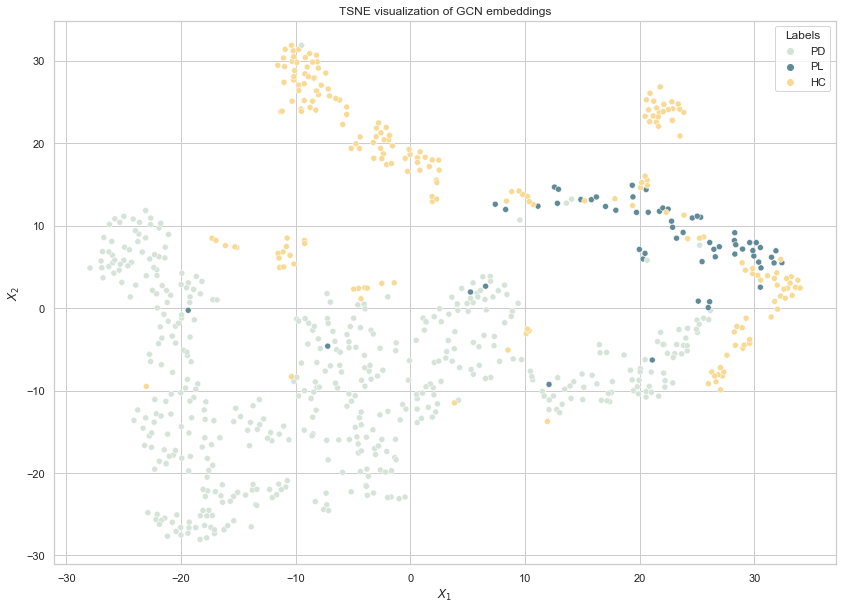

In [18]:
tsne_plot , GNN_embeddings = GNN.transform_plot(model , generator , node_subjects , pd.Series(nx.get_node_attributes(G , 'idx')).values , TSNE)

1/1 [==============================] - 0s 93ms/step


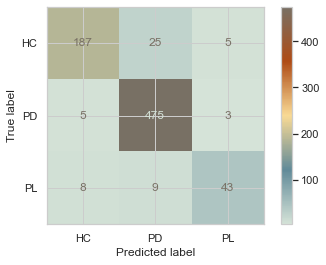

In [19]:
cmplt , pred = GNN.gnn_confusion_matrix(model , generator , node_subjects , mlb)
cmplt.plot(  cmap = Darjeeling2_5.mpl_colormap )

1/1 [==============================] - 0s 34ms/step


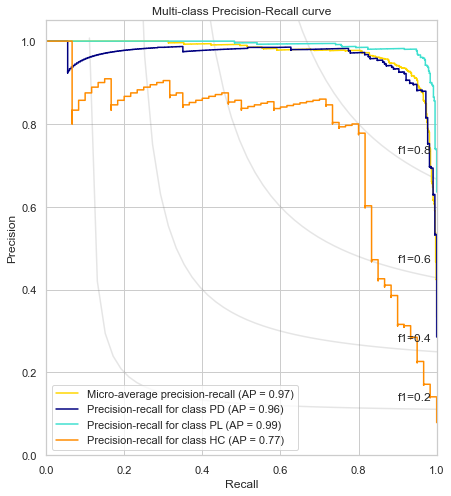

In [20]:
precision_recall_plot , all_predictions_conf = GNN.gnn_precision_recall(model , generator , node_subjects , mlb)

In [21]:
all_predictions = []
for pred , max_pred in zip(all_predictions_conf , np.max(all_predictions_conf, axis=1)) : 
    all_predictions.append(list(pred == max_pred))
node_predictions = mlb.inverse_transform(np.array(all_predictions))

node_predictions = [i[0] for i in node_predictions]

pred_df = pd.DataFrame({'Actual' : datMeta.loc[pd.Series(nx.get_node_attributes(G , 'idx'))] , 'Predicted' : node_predictions})

In [22]:
pred_df

,Actual,Predicted
3001,PD,PD
3003,PD,PD
3006,PD,PD
3010,PD,PD
3018,PD,PD
...,...,...
144147,PD,PD
3950,HC,PD
144254,PD,PD
160252,PD,PD
